# Import section 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import keras 
from keras.utils import np_utils

from keras.layers.core import Dense, Activation,Dropout 
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling2D, AveragePooling2D,UpSampling2D
from keras.layers import Conv2D, Flatten,Input
from keras.optimizers import SGD
from keras.utils import to_categorical

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Generating Images

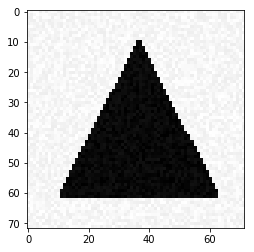

In [9]:
import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Simple Classification

In [3]:
#generate a training set of images of simple geometric shapes
[X_train, Y_train] = generate_dataset_classification(300, 20)

## convert Y to a categorical vector
Y_train=np_utils.to_categorical(Y_train)
Y_train

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0

#### Test a linear structure 

In [22]:
#Try a linear classifier with an adam optimiser
[X_train_Adam,Y__train_Adam]=[X_train, Y_train]

input_shape = X_train_Adam.shape[1]
nb_neurons = 3

model_Adam = Sequential()

# the sigmoid activation function gives the best accuracy
model_Adam.add(Dense(nb_neurons,activation='sigmoid'))
model_Adam.add(Activation("softmax"))

model_Adam.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

I tried many activation functions like relu and tanh activation functions but the sigmoid activation function gives the best accuracy



In [23]:
model_Adam.fit(X_train, Y_train, epochs=35, batch_size=32)

Epoch 1/35
300/300 [==============================] - 0s 929us/step - loss: 1.0843 - acc: 0.4400
Epoch 2/35
300/300 [==============================] - 0s 71us/step - loss: 0.9576 - acc: 0.6233
Epoch 3/35
300/300 [==============================] - 0s 58us/step - loss: 0.8687 - acc: 0.7167
Epoch 4/35
300/300 [==============================] - 0s 68us/step - loss: 0.8209 - acc: 0.7500
Epoch 5/35
300/300 [==============================] - 0s 59us/step - loss: 0.7875 - acc: 0.7767
Epoch 6/35
300/300 [==============================] - 0s 63us/step - loss: 0.7630 - acc: 0.8033
Epoch 7/35
300/300 [==============================] - 0s 63us/step - loss: 0.7351 - acc: 0.8867
Epoch 8/35
300/300 [==============================] - 0s 62us/step - loss: 0.7120 - acc: 0.8733
Epoch 9/35
300/300 [==============================] - 0s 67us/step - loss: 0.6964 - acc: 0.9033
Epoch 10/35
300/300 [==============================] - 0s 66us/step - loss: 0.6720 - acc: 0.9533
Epoch 11/35
300/300 [=================

By running the model many times we obtain an accuracy of 100% on the training set and a loss function of 0.57.

The classifier has a local minima and sometimes it doesn't converge, Thus sometimes I tried to run it more than one time

In [26]:
X_test = generate_a_disk()

X_test = X_test.reshape(1, X_test.shape[0])
model_Adam.predict(X_test)
print ('the class of X_test is ',model_Adam.predict_classes(X_test))
print( 'probabilities are given by ',model_Adam.predict(X_test))

the class of X_test is  [1]
probabilities are given by  [[0.21194157 0.5761169  0.21194157]]


In [35]:
#Try a linear classifier with an adam optimiser
[X_train_SGD,Y_train_SGD]=[X_train, Y_train]

input_shape = X_train_SGD.shape[1]
nb_neurons = 3

model_SGD = Sequential()
#model.add(Dense(input_shape, activation='linear'))
model_SGD.add(Dense(nb_neurons,activation='sigmoid'))
model_SGD.add(Activation("softmax"))

model_SGD.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [36]:
model_SGD.fit(X_train_SGD, Y_train_SGD, epochs=50, batch_size=32)

Epoch 1/50
300/300 [==============================] - 0s 1ms/step - loss: 1.0966 - acc: 0.3900
Epoch 2/50
300/300 [==============================] - 0s 67us/step - loss: 1.0352 - acc: 0.5267
Epoch 3/50
300/300 [==============================] - 0s 59us/step - loss: 0.9993 - acc: 0.5633
Epoch 4/50
300/300 [==============================] - 0s 51us/step - loss: 0.9615 - acc: 0.6800
Epoch 5/50
300/300 [==============================] - 0s 65us/step - loss: 0.9419 - acc: 0.6600
Epoch 6/50
300/300 [==============================] - 0s 58us/step - loss: 0.9062 - acc: 0.7567
Epoch 7/50
300/300 [==============================] - 0s 60us/step - loss: 0.8997 - acc: 0.7133
Epoch 8/50
300/300 [==============================] - 0s 59us/step - loss: 0.8869 - acc: 0.7000
Epoch 9/50
300/300 [==============================] - 0s 59us/step - loss: 0.8642 - acc: 0.7100
Epoch 10/50
300/300 [==============================] - 0s 69us/step - loss: 0.8450 - acc: 0.8367
Epoch 11/50
300/300 [===================

In [38]:
X_test = generate_a_disk()

X_test = X_test.reshape(1, X_test.shape[0])
model_SGD.predict(X_test)

array([[0.21194157, 0.5761169 , 0.21194157]], dtype=float32)

# 4 Visualization of the Solution

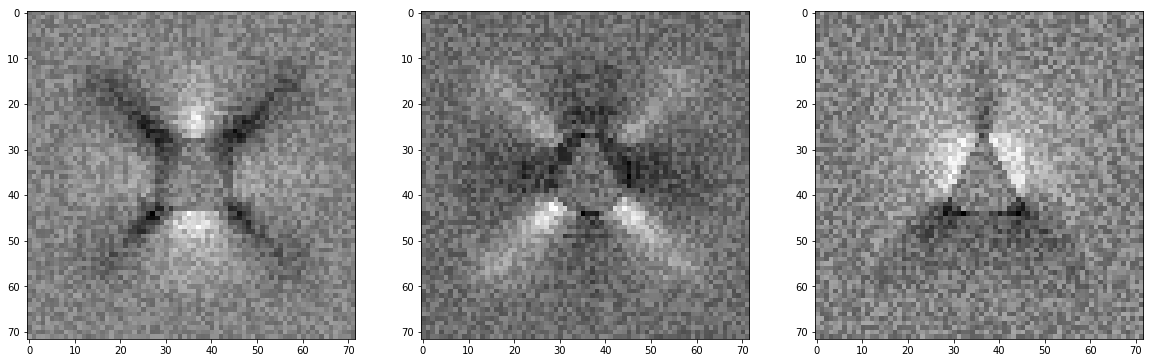

In [39]:
W=model_Adam.get_weights()
Col1=W[0][:,0]
Col2=W[0][:,1]
Col3=W[0][:,2]
fig,(ax0,ax1,ax2)=plt.subplots(ncols=3,figsize=(20,10))
ax0.imshow(Col1.reshape(72,72),cmap='gray')
ax1.imshow(Col2.reshape(72,72),cmap='gray')
ax2.imshow(Col3.reshape(72,72),cmap='gray')

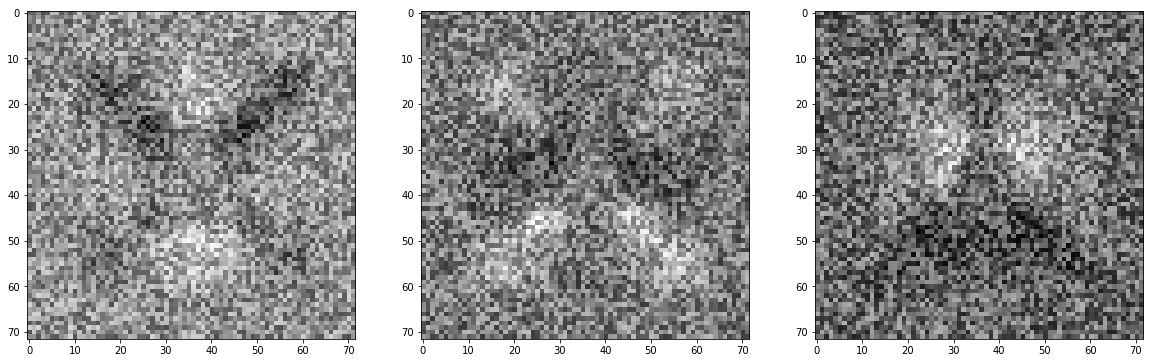

In [40]:
W=model_SGD.get_weights()
Col1=W[0][:,0]
Col2=W[0][:,1]
Col3=W[0][:,2]
fig,(ax0,ax1,ax2)=plt.subplots(ncols=3,figsize=(20,10))
ax0.imshow(Col1.reshape(72,72),cmap='gray')
ax1.imshow(Col2.reshape(72,72),cmap='gray')
ax2.imshow(Col3.reshape(72,72),cmap='gray')

# The first model with an adam optimizer gives better results than the second model with an SGD optimizer

The first model with an adam optimizer gives better results than the the one with an SGD optimizer.
Thus, weights of the first model are much more clear than the second One.

### 5 A More Difficult Classification Problem

In [41]:
[X_train_RandomP, Y_train_RandomP] = generate_dataset_classification(300, 20, True)

## convert Y to a categorical vector
Y_train_RandomP=np_utils.to_categorical(Y_train_RandomP)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [87]:
# Train the same classifier as in part 3
input_shape = X_train_RandomP.shape[1]
nb_neurons = 3

model_RandomP = Sequential()

model_RandomP.add(Dense(nb_neurons,activation='sigmoid'))
model_RandomP.add(Activation("softmax"))

model_RandomP.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [88]:
model_RandomP.fit(X_train_RandomP, Y_train_RandomP, epochs=30, batch_size=32)

Epoch 1/30
300/300 [==============================] - 1s 2ms/step - loss: 1.1154 - acc: 0.3200
Epoch 2/30
300/300 [==============================] - 0s 73us/step - loss: 1.1100 - acc: 0.3733
Epoch 3/30
300/300 [==============================] - 0s 68us/step - loss: 1.1098 - acc: 0.3400
Epoch 4/30
300/300 [==============================] - 0s 67us/step - loss: 1.0896 - acc: 0.3767
Epoch 5/30
300/300 [==============================] - 0s 71us/step - loss: 1.0846 - acc: 0.3767
Epoch 6/30
300/300 [==============================] - 0s 72us/step - loss: 1.0758 - acc: 0.3333
Epoch 7/30
300/300 [==============================] - 0s 72us/step - loss: 1.0607 - acc: 0.4533
Epoch 8/30
300/300 [==============================] - 0s 78us/step - loss: 1.0573 - acc: 0.4433
Epoch 9/30
300/300 [==============================] - 0s 73us/step - loss: 1.0516 - acc: 0.4533
Epoch 10/30
300/300 [==============================] - 0s 78us/step - loss: 1.0360 - acc: 0.5167
Epoch 11/30
300/300 [===================

In [89]:
# Evaluate the new classifier on a test set
[X_test, Y_test] = generate_test_set_classification()
model_RandomP.evaluate(X_test, Y_test)

# the accuracy of the clssifier trained on the test set is very low due to the noise in the training set

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 969us/step


[0.9856583317120869, 0.5333333325386047]

A linear classifier gives smaller accuracy when the shapes are allowed to move. In this case an SGD optimiser gives a better results than an ADAM one. We obtail an loss functio equal to 0.98 and an accuracy of 0.53

A convolutional neural network could improve this accuracy.

### Train a convolutional neural network in order to improve the accuracy 

In [91]:
# Increasing the number of training samples helps to improve the accuracy of the classifier
[X_train_CNN, Y_train_CNN] = generate_dataset_classification(1200, 20, True)
X_train_CNN = X_train_CNN.reshape(1200,72,72,1)
Y_train_CNN = np_utils.to_categorical(Y_train_CNN, 3) 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190


In [95]:
# Train a covolutional neural network with a 16 5x5 filters

model_CNN = Sequential([
    Conv2D(filters=16, kernel_size=(5, 5), padding="same",
           input_shape=(72, 72, 1))
])
# Add a Pooling layer and a fully connected layer

model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Flatten())
model_CNN.add(Dense(3, activation ='sigmoid'))
model_CNN.add(Activation('softmax'))


model_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN.fit(X_train_CNN, Y_train_CNN, epochs=20, batch_size=32, validation_split=0.1)



Train on 1080 samples, validate on 120 samples
Epoch 1/20
1080/1080 [==============================] - 3s 3ms/step - loss: 1.1013 - acc: 0.4213 - val_loss: 1.0788 - val_acc: 0.3500
Epoch 2/20
1080/1080 [==============================] - 2s 2ms/step - loss: 1.0095 - acc: 0.5111 - val_loss: 0.9724 - val_acc: 0.6083
Epoch 3/20
1080/1080 [==============================] - 2s 2ms/step - loss: 0.9145 - acc: 0.6343 - val_loss: 0.9337 - val_acc: 0.5750
Epoch 4/20
1080/1080 [==============================] - 2s 2ms/step - loss: 0.8604 - acc: 0.7343 - val_loss: 0.9249 - val_acc: 0.6333
Epoch 5/20
1080/1080 [==============================] - 2s 2ms/step - loss: 0.8388 - acc: 0.7389 - val_loss: 0.9131 - val_acc: 0.5917
Epoch 6/20
1080/1080 [==============================] - 2s 2ms/step - loss: 0.8290 - acc: 0.7241 - val_loss: 0.8932 - val_acc: 0.6333
Epoch 7/20
1080/1080 [==============================] - 2s 2ms/step - loss: 0.8080 - acc: 0.7796 - val_loss: 0.9006 - val_acc: 0.6000
Epoch 8/20
1080

With a CNN model the accuracy has improved to reach approximately 82%. This accuracy could be improved by using more epochs and more training samples. The loss function has also improved to reach 0.68

The classifier has a local minimum, so in order to have a good accuracy I tried to train it many times with 20 epochs each time.

In [96]:
X_test = generate_a_disk()
X_test = X_test.reshape(1,72,72,1)
#X_test = X_test.reshape(1, X_test.shape[0])
model_CNN.predict(X_test)

array([[0.21194156, 0.21194156, 0.57611686]], dtype=float32)

In [97]:
[X_test, Y_test] = generate_test_set_classification()
X_test=X_test.reshape(300,72,72,1)
model_CNN.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 919us/step


[0.7869090978304545, 0.7633333325386047]

The accuracy on a test set has considerably improved with the new CNN model

# 6 A Regression Problem

In [4]:
[X_train_regr, Y_train_regr] = generate_dataset_regression(3000, 20)
[X_valid_regr,Y_valid_regr]=generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [5]:
# reshape X_train_regr and X_valid_regr before training a CNN classifier 
X_train_regr=X_train_regr.reshape(3000,72,72,1)
X_valid_regr=X_valid_regr.reshape(300,72,72,1)

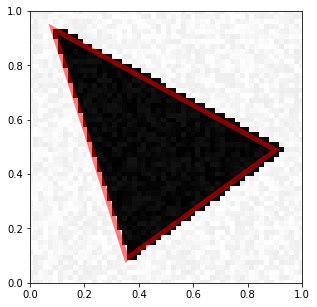

In [17]:
visualize_prediction(X_train_regr[4], Y_train_regr[4])

In [7]:
# Normalize the vertices in Y_train_regr
#Change Y_regr to have coordinates writen in this format [x1,x2,x3,y1,y2,y3] for each triangle, xi and yi are sorted 

Y_regr_modif=np.zeros(Y_train_regr.shape)
for i in range(len(Y_regr_modif)):
    Y_regr_modif[i] = np.array(sorted( Y_train_regr[i].reshape(3,2), key = lambda x: x[0])).reshape(6,)

In [8]:
Y_valid_modif=np.zeros(Y_valid_regr.shape)
for i in range(len(Y_valid_modif)):
    Y_valid_modif[i] = np.array(sorted( Y_valid_regr[i].reshape(3,2), key = lambda x: x[0])).reshape(6,)

In [13]:
# The best model that I created is a CNN classifier with a covolutional 32X5X5, a covolutional 64x5x5 layer, a polling layer 
# and a fully connected layer

model_CNN_regr=Sequential()

model_CNN_regr.add(Conv2D(32,kernel_size=(3,3),input_shape=(72,72,1)))

model_CNN_regr.add(Conv2D(64,kernel_size=(4,4),input_shape=(72,72,1)))

model_CNN_regr.add(MaxPooling2D(pool_size=(3,3)))

model_CNN_regr.add(Flatten())

model_CNN_regr.add(Dense(6,activation='sigmoid'))

model_CNN_regr.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])

model_CNN_regr.summary()

model_CNN_regr.fit(X_train_regr,Y_regr_modif,epochs=10,batch_size=32)

# The loss function could be minimized by using more training set and larger epocochs


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 70, 70, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 67, 67, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 185862    
Total params: 219,014
Trainable params: 219,014
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3000/3000 [==============================] - 49s 16ms/step - loss: 0.0633 - mean_squared_error: 0.0633
Epoch 2/10
3000/3000 [

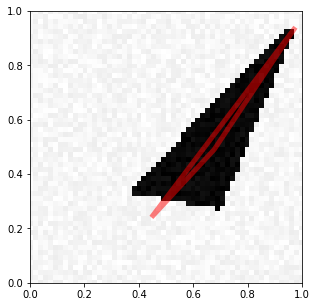

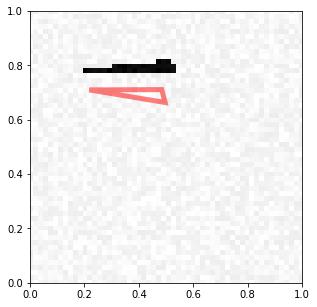

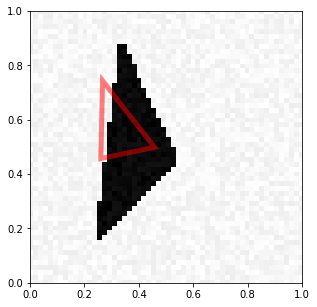

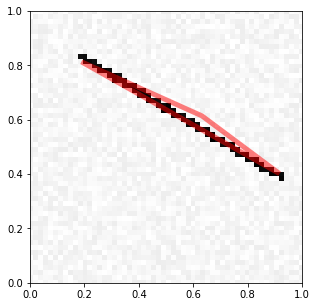

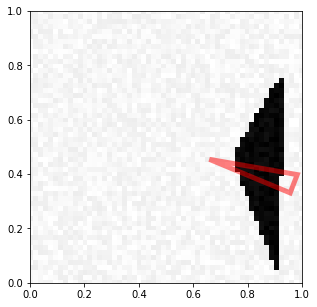

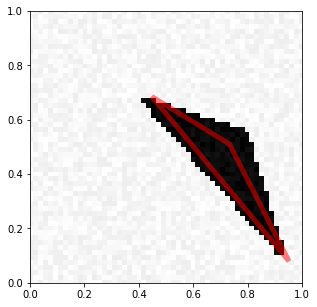

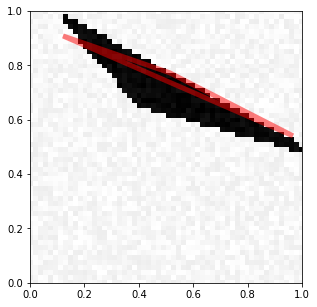

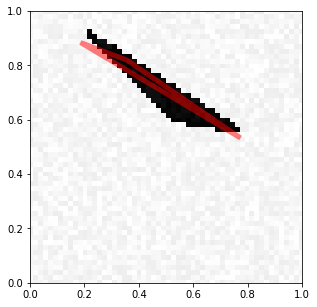

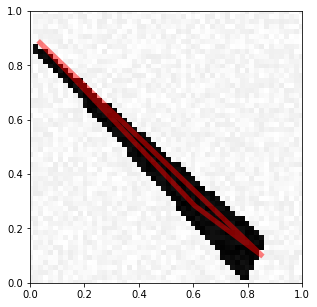

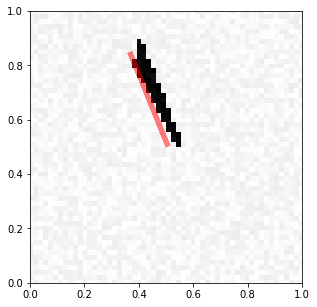

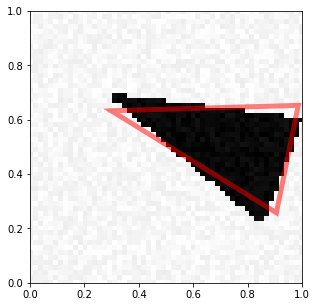

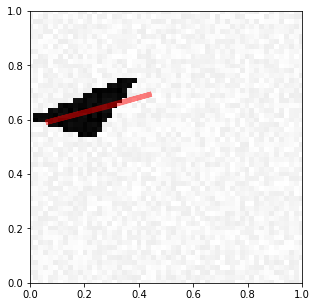

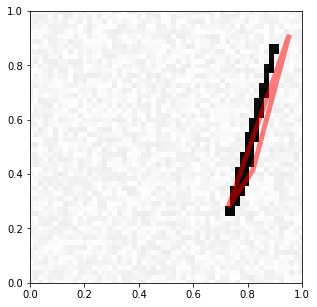

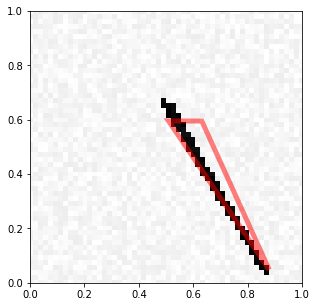

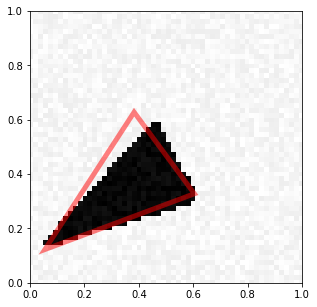

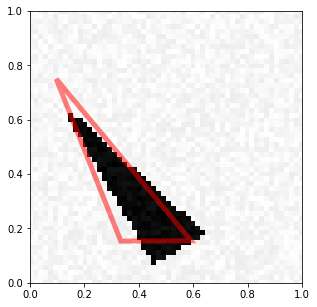

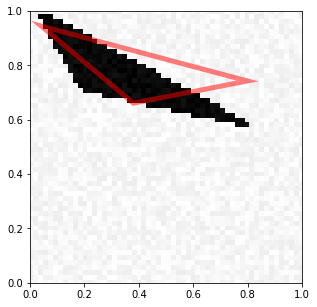

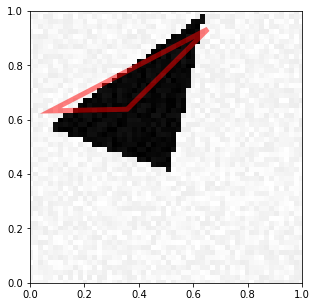

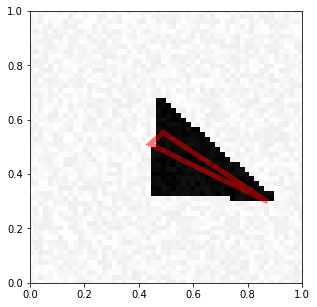

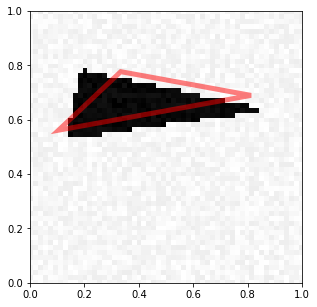

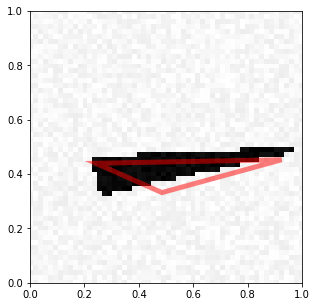

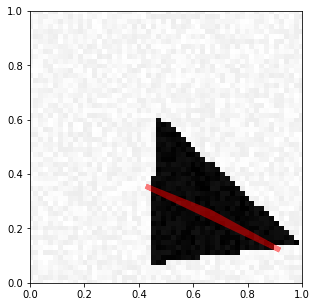

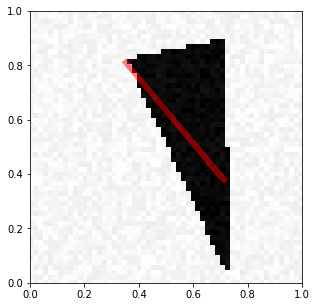

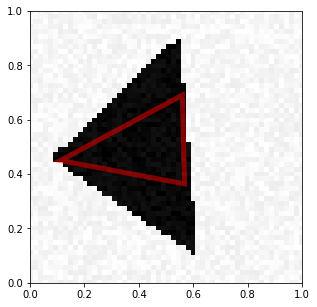

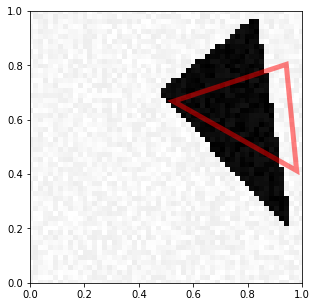

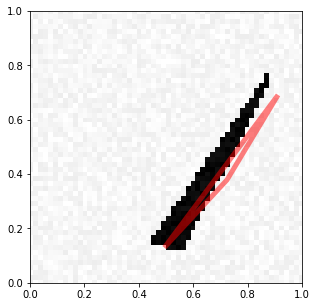

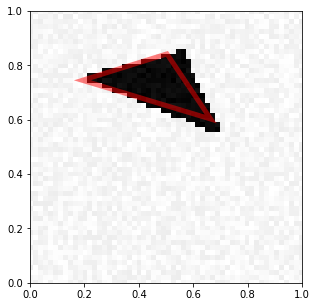

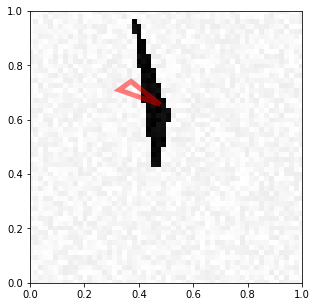

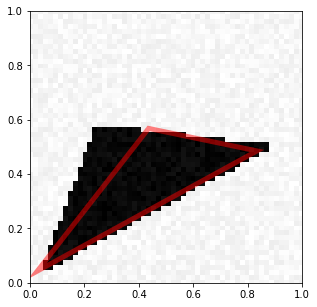

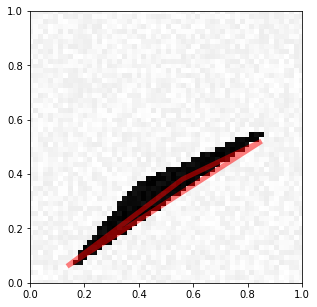

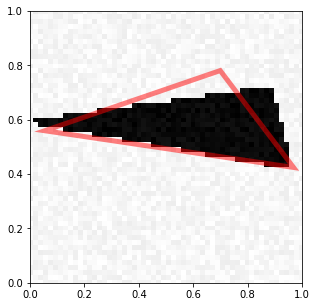

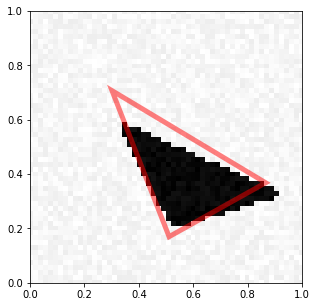

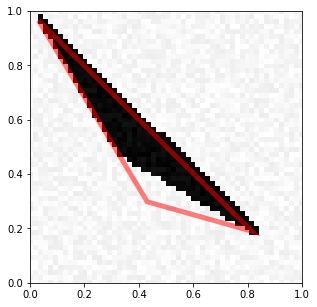

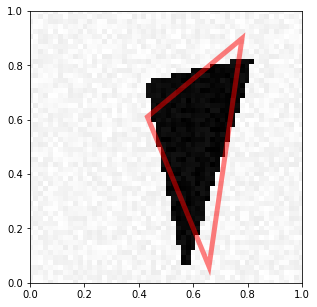

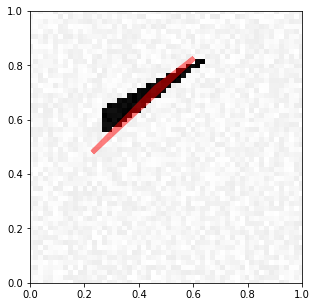

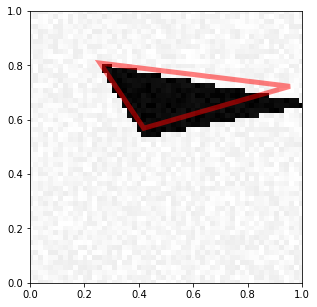

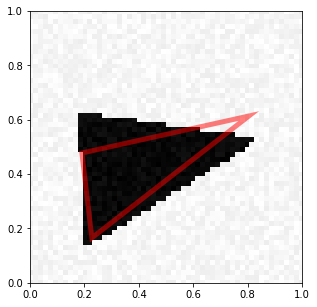

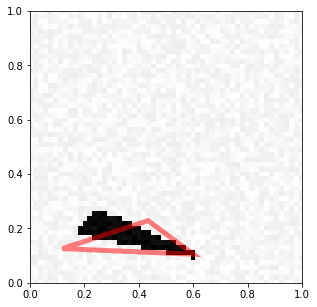

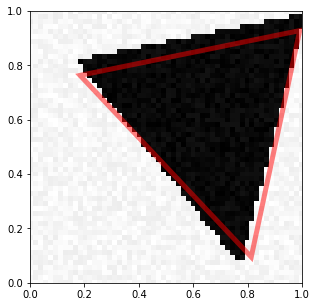

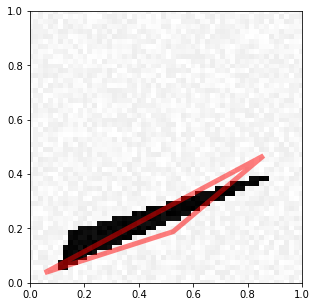

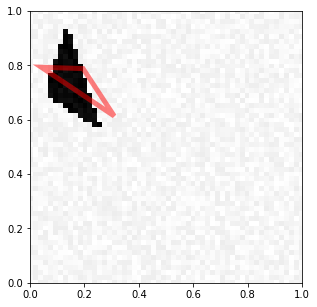

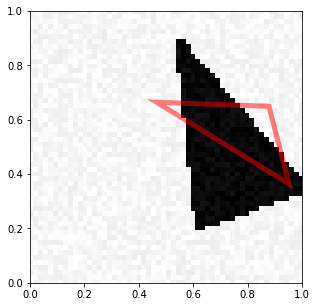

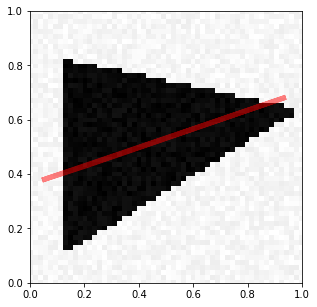

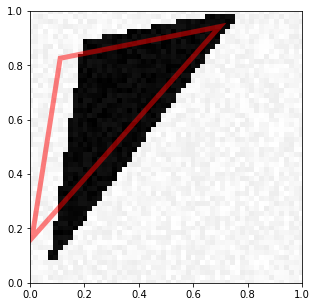

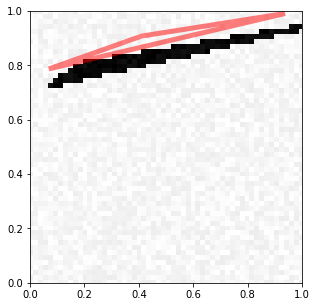

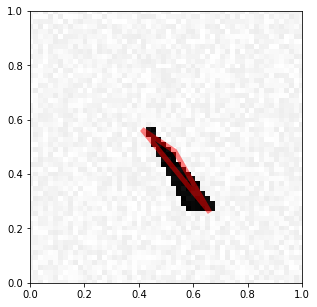

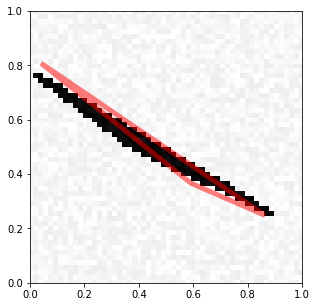

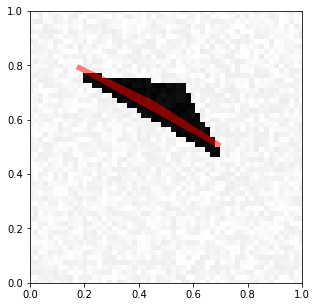

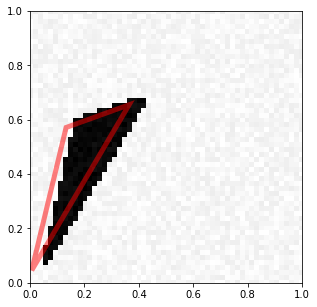

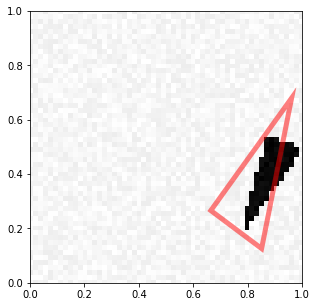

In [14]:
X=X_valid_regr
Y=Y_valid_regr
Y_test=model_CNN_regr.predict(X_valid_regr)

for i in range(50):
    visualize_prediction(X_valid_regr[i],Y_test[i] )
    


# Result can be improved by using larger training set, generating 10000 training set gives much better results

The model loss function could be improved by using larger training set and more epochs but in this case the complexitty would be very large. I tried to run it by generating a data set of 10000 training samples and 100 epochs and I managed to obtain better results.

In [15]:
model_CNN_regr.evaluate(X_valid_regr,Y_valid_regr)

300/300 [==============================] - 2s 6ms/step


[0.10365114549795787, 0.10365114549795787]

# Image Denoising

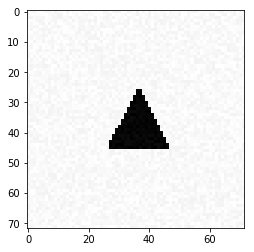

In [13]:

# Change the initial code to genrate two images each time. A clear image and a noised one with a random noise.

IMAGE_SIZE = 72

def generate_2_drawings(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    # Add a random noise 
    rand_noise = np.random.randint(10,20)
    noise = noise + rand_noise
    imdata_clean = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noised = imdata_clean + noise * np.random.random(imdata_clean.size)
    plt.close(fig)
    return  imdata_noised,imdata_clean

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    # return two images. A clear one and a noised one.
    return generate_2_drawings(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    mean = 6
    var = 0.5
    sigma = var**0.5
    noise = np.random.normal(mean,sigma)
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    # return two images. A clear one and a noised one.
    return generate_2_drawings(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    mean = 6
    var = 0.5
    sigma = var**0.5
    noise = np.random.normal(mean,sigma)
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata1,imdata2 = generate_2_drawings(figsize, U, V, 0)
    # return two images. A clear one and a noised one.
    return [imdata1, [U[0], V[0], U[1], V[1], U[2], V[2]]],[imdata2, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)[0]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)[0]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)[0]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_Two_datasets(nb_samples, noise=0.0, free_location=False):
    # Our datasets will now be composed of noised images and clear ones. Our goal will be to predict
    #a clear image from a noised one.
    
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i],Y[i] = generate_a_disk(noise, free_location) 
        else:
            [X[i], V],[Y[i],V] = generate_a_triangle(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set():
    np.random.seed(42)
    [X_test, Y_test] = generate_Two_datasets(300)
    return [X_test, Y_test]

In [3]:
[X_train_noised, X_train_clean] = generate_Two_datasets(3000)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [4]:
X_train_noised=X_train_noised.reshape(3000,72,72,1)
X_train_clean=X_train_clean.reshape(3000,72,72,1)

In [5]:
# Creating a model to predict clear image from a noised one using different layers. 
# Layers are chosen to minimize the loss fonction 
auto_encodeur_Noise = Sequential()

auto_encodeur_Noise.add(Conv2D(64, kernel_size = (3, 3), activation='relu', padding='same',  input_shape = (72,72,1)))
auto_encodeur_Noise.add(Conv2D(32, kernel_size = (3, 3), activation='relu',padding='same'))
auto_encodeur_Noise.add(MaxPooling2D(pool_size= (2, 2)))

auto_encodeur_Noise.add(Conv2D(16, kernel_size = (3, 3),activation='relu' , padding='same'))

auto_encodeur_Noise.add(Conv2D(16, kernel_size = (3, 3),activation='relu', padding='same'))

auto_encodeur_Noise.add(UpSampling2D(size = (2, 2)))
auto_encodeur_Noise.add(Conv2D(32, kernel_size = (3, 3),activation='relu', padding='same'))
auto_encodeur_Noise.add(Conv2D(64, kernel_size = (3, 3), activation='relu',padding='same'))


auto_encodeur_Noise.add(Conv2D(1, kernel_size = (3, 3),activation='relu', padding='same'))

auto_encodeur_Noise.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['mse'])

auto_encodeur_Noise.summary()

# Apply the auto_encoder to our training set. I adjusted the different layers to improve loss function at each time
FitData = auto_encodeur_Noise.fit(X_train_noised, X_train_clean, epochs= 15, batch_size = 32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 16)        4624      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 16)        2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        4640      
__________

ValueError: cannot reshape array of size 5184 into shape (3,2)

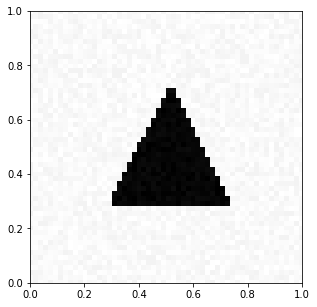

In [10]:
visualize_prediction(X_train_noised[5],X_train_clean[5])

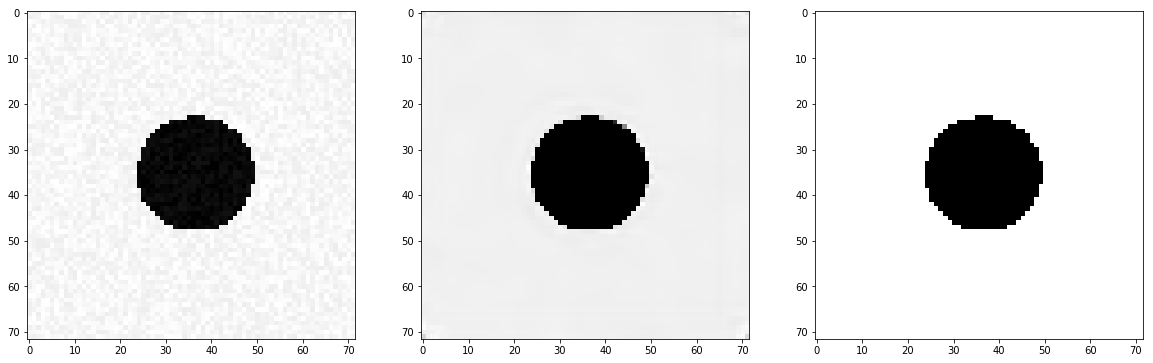

In [8]:
fig,(ax0,ax1,ax3)=plt.subplots(ncols=3,figsize=(20,10))
ax0.imshow(X_train_noised[6].reshape(72,72),cmap='gray')
ax1.imshow(auto_encodeur_Noise.predict(X_train_noised[6].reshape(1,72,72,1)).reshape(72,72),cmap='gray')
ax3.imshow(X_train_clean[6].reshape(72,72),cmap='gray')

The classifier accuracy could be improved by using larger dataset and more epochs during the optimisation. We observe that the classifier loss function continue to decrease. 

I tried to use a model with only rectangles as inputs and I obtained a loss function equal to 5. 

In [15]:
[X_test_noised, X_test_clean] = generate_Two_datasets(10)

Creating data:
0


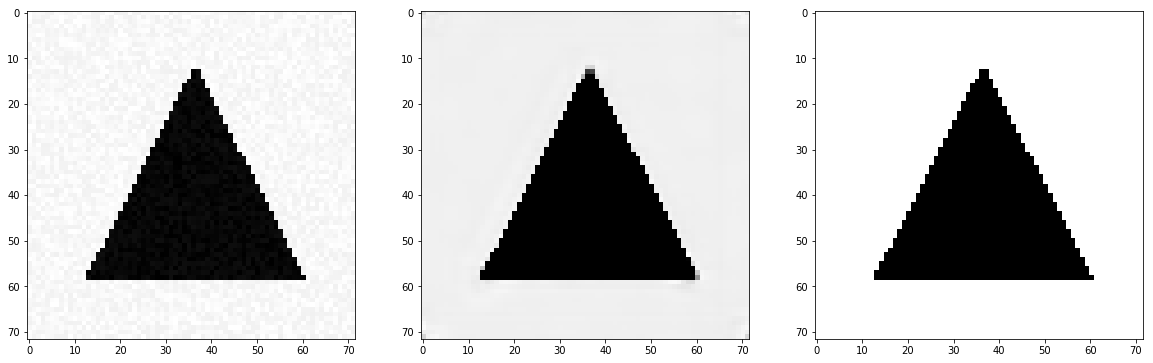

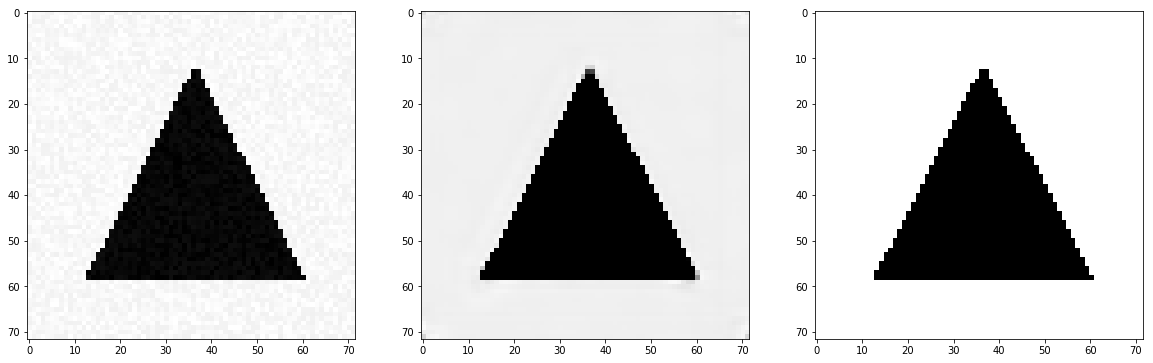

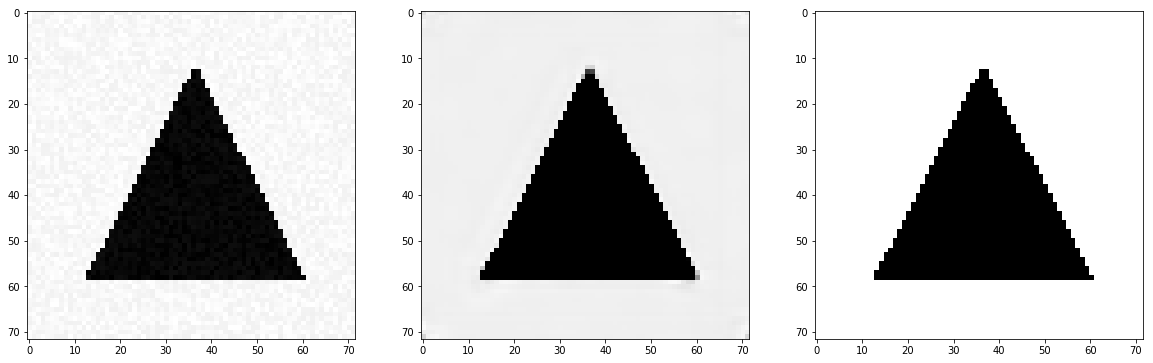

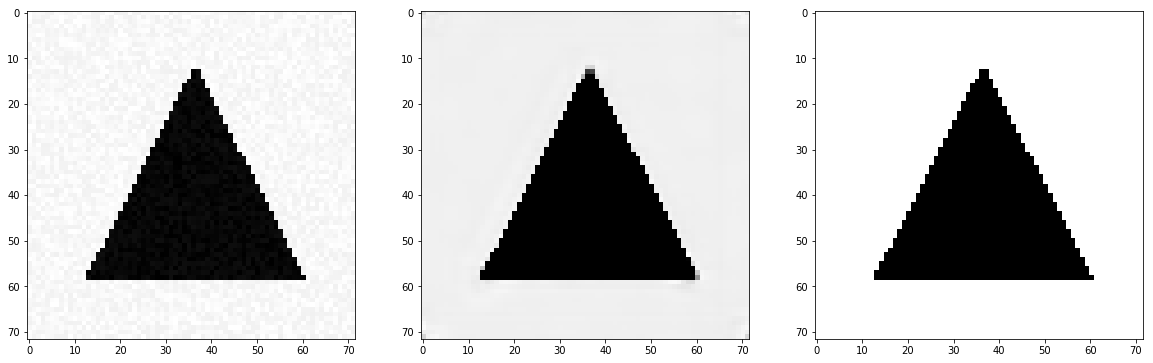

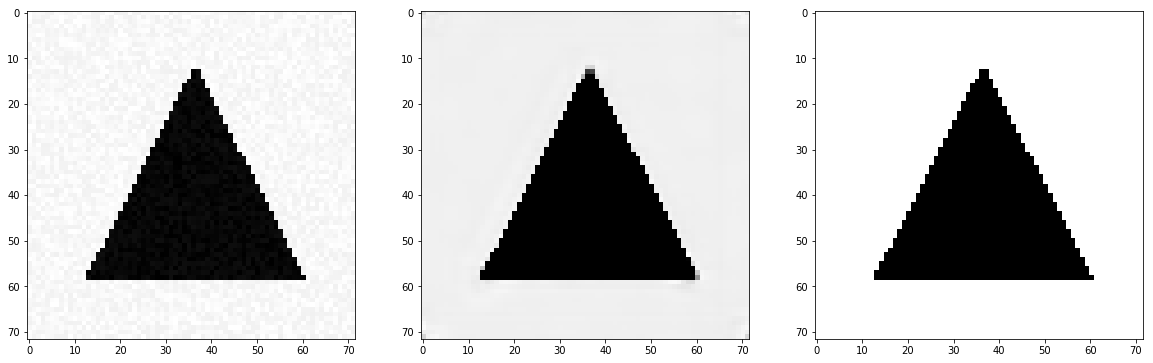

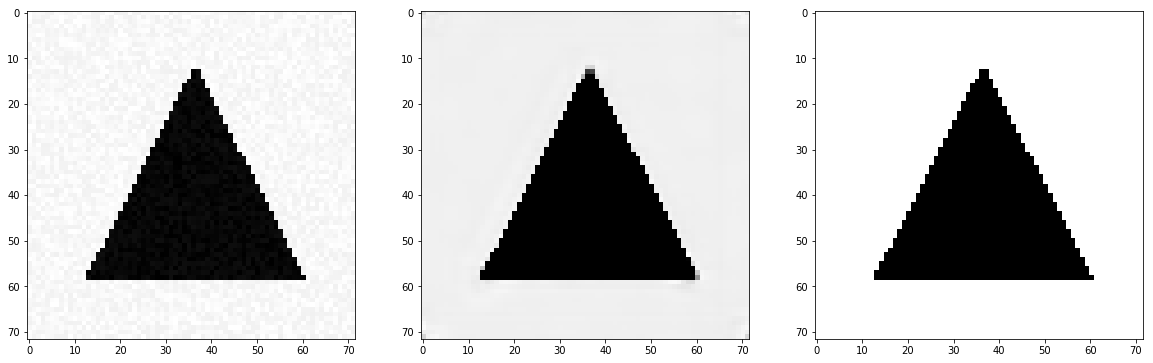

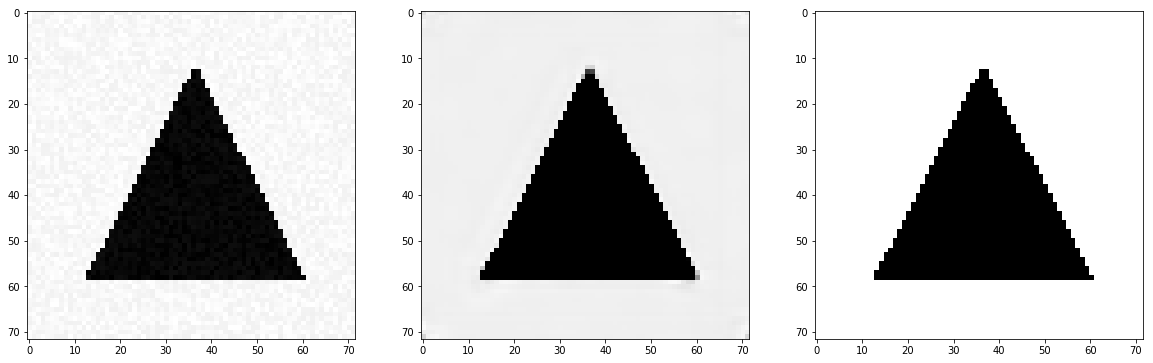

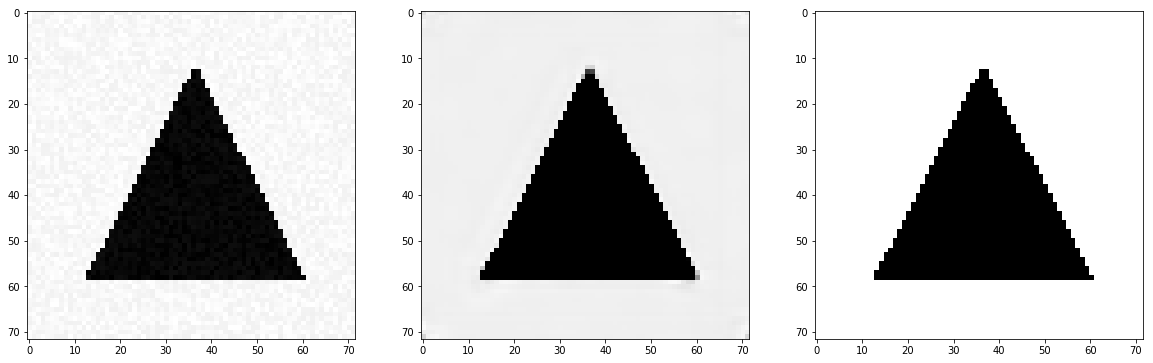

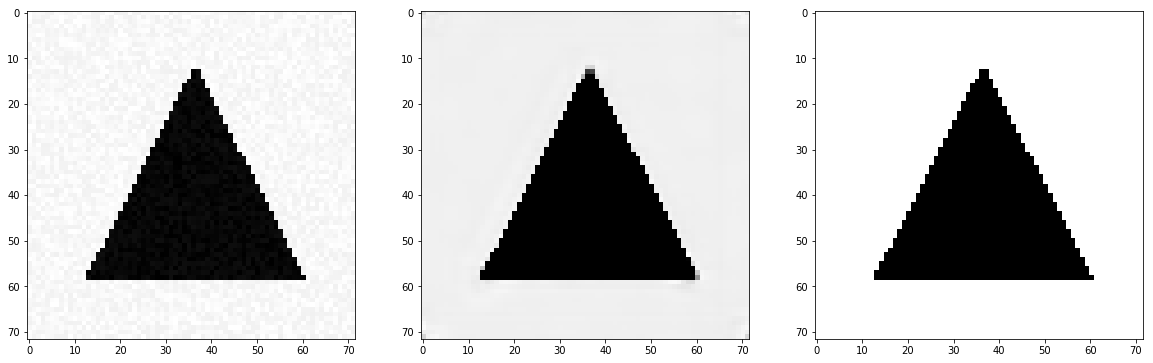

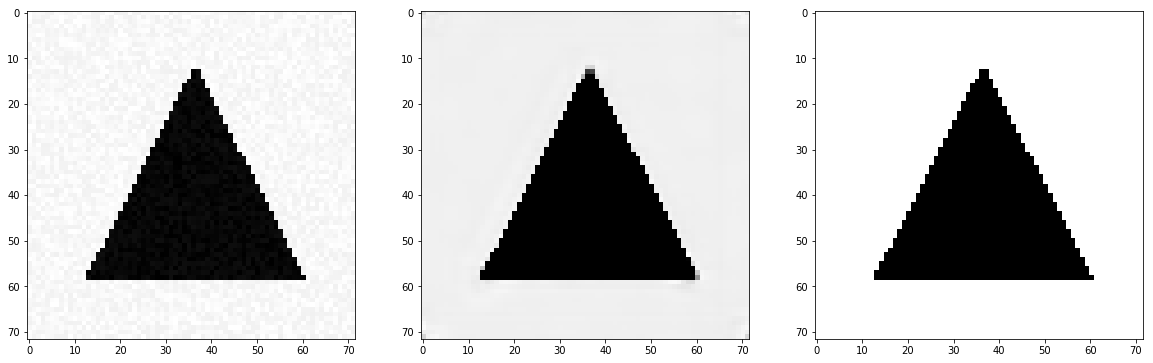

In [16]:
# Results on a test samples

for i in range(10):
    
    fig,(ax0,ax1,ax3)=plt.subplots(ncols=3,figsize=(20,10))
    ax0.imshow(X_test_noised[6].reshape(72,72),cmap='gray')
    ax1.imshow(auto_encodeur_Noise.predict(X_test_noised[6].reshape(1,72,72,1)).reshape(72,72),cmap='gray')
    ax3.imshow(X_test_clean[6].reshape(72,72),cmap='gray')
    